In [ ]:
'''
    ***** RECOMMENDATION SYSTEM USING SURPRISE LIBRARY for User/Book Rating *****

A. This notebook covers following aspects:
    a. How to visualize data distribution in case of Recommendation Systems
    b. How to filter out the data and remove unnecessary data 
    c. Why and how to use 'Weightate Rating' in Recommendation System
    c. How to train and test Recommendation system using Surprise Library
    d. How to evvalaute model accuracy using Surprise Library
    e. How to get Top 'n' worst and best recommendation by model algorithm
    f. How to predict a rating for a given user id and book id combination with different algorithms
    
A. This notebook has implementation of recommendation system for Book Rating database using SURPRISE library with following 
    algorithms:
    a. SVD (Singular value decomposition)
    b. NMF
    c. KNNBaseline default
    d. KNNBaseline item-item similarity
    e. KNNBaseline user-user similarity
    f. Slope-one
    
B. This notebook is using 'Dataset.load_from_df' to load/referred data as supported by Surprise Library such as:
C. This notebook is using 'model_selection.train_test_split' splitting data into training and testing dataset:
    
'''

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [25]:
# Part-1  - Load the User-Book Rating dataset

user = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']

rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

original_df = pd.merge(user, rating, on='userID', how='inner')
original_df.drop(['Location', 'Age'], axis=1, inplace=True)
original_df.head()

user_column_name = 'userID'
item_column_name = 'ISBN'
output_label_column = 'bookRating'

In [31]:
'''
Part-2  - To reduce the size of dataset, lets filter out 
    A. all user id which has given less than 50 ratings 
    B. Also, all books (ISBN) which are being rating less than 50 times
    
'''

min_book_ratings = 50
filter_books = original_df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = original_df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df = original_df[(original_df['ISBN'].isin(filter_books)) & (original_df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(original_df.shape))
print('The new filtered data frame shape:\t{}'.format(df.shape))

print(df[:10].to_string())

The original data frame shape:	(1149780, 3)
The new filtered data frame shape:	(140516, 3)
     userID        ISBN  bookRating
394     243  0060915544          10
395     243  0060977493           7
397     243  0156006529           0
400     243  0316096199           0
401     243  0316601950           9
402     243  0316602906           0
403     243  0316666343           0
404     243  0316693006           0
405     243  0316776963           9
406     243  0316899984           7


In [18]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if attribute == 'moviePubYear':
        dataset = dataset[dataset['moviePubYear'] != 9999]
        
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.hist(dataset[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)
    

def make_bar_chart(dataset, attribute, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=True):
    '''
    if sort_index == False:
        xs = dataset[attribute].value_counts().index
        ys = dataset[attribute].value_counts().values
    else:
        xs = dataset[attribute].value_counts().sort_index().index
        ys = dataset[attribute].value_counts().sort_index().values
        
    '''
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.bar(x=dataset[attribute], height=dataset['bookRating'], color=bar_color, edgecolor=edge_color, linewidth=2)
    plt.xticks(rotation=45)

            count
bookRating       
0           98813
1             140
2             210
3             356
4             607
5            3654
6            2917
7            6694
8           10381
9            7966
10           8778


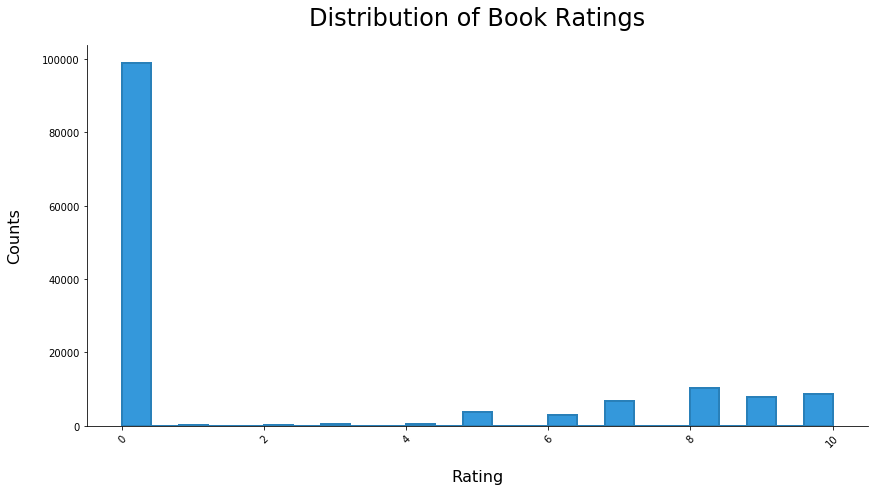

In [23]:
# Part-3-A - Perform some data engineering to understand and visualize the data distribution

'''
    Distribution of Book Ratings. As 'bookRating' scale is from 0 to 10.
    So 'df_ratings_count' will have max '11' rows - each for for individual rating. 
'''
df_ratings_count = pd.DataFrame(df.groupby('bookRating').size(), columns=['count'])
print(df_ratings_count.head(15))

# Or we can use below line code to get the count of each bookRating
data = df['bookRating'].value_counts().sort_index(ascending=False)


make_histogram(df, 'bookRating', title='Distribution of Book Ratings', xlab='Rating', ylab='Counts')

   userID  bookRating
0   11676        1552
1   35859         732
2   76352         664
3   16795         599
4  153662         554
5  102967         515
6   55492         506
7   78783         482
8  232131         480
9  198711         468


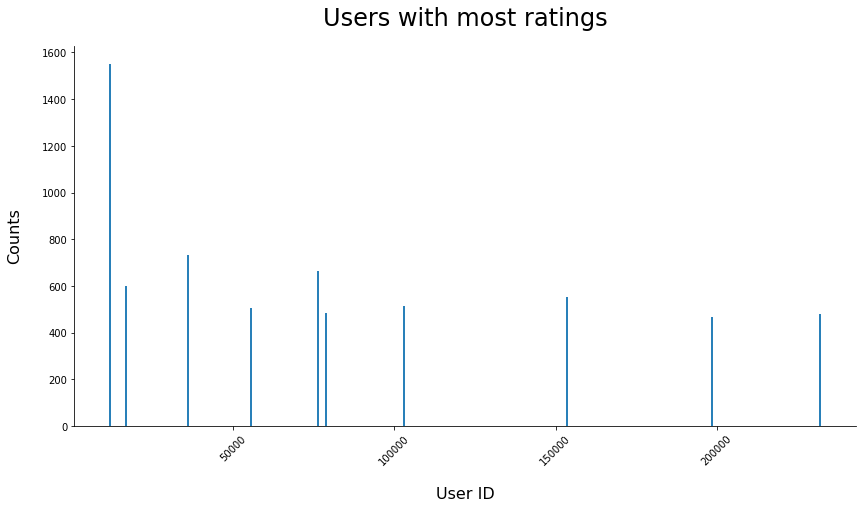

In [22]:
# Part-3-B - Perform some data engineering to understand and visualize the data distribution

'''
 Top 10 users who has given most rating to different books
'''

user_with_most_ratings = pd.DataFrame(df.groupby(user_column_name).count()[output_label_column]).sort_values(by=
                                                                output_label_column, ascending=False)[:10].reset_index()
print(user_with_most_ratings.head(15))

# or below lint to get Top 10 used with most given rating
user_with_most_ratings1 = df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]
# print(user_with_most_ratings1.head(15))

make_bar_chart(user_with_most_ratings, 'userID', title='Users with most ratings', xlab='User ID', ylab='Counts')

            bookRating
ISBN                  
0971880107         844
0316666343         574
0385504209         434
0060928336         375
0312195516         341
044021145X         333
067976402X         324
0440214041         320
0440211727         320
0142001740         310


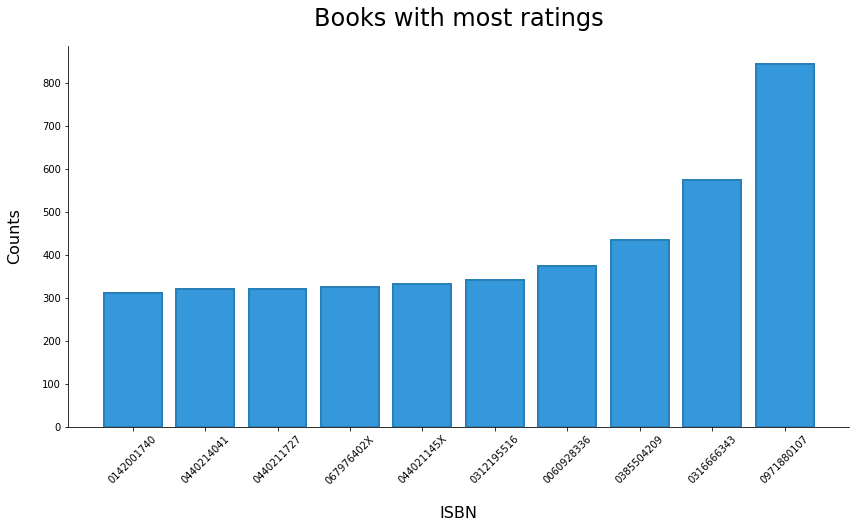

In [28]:
# Part-3-C - Perform some data engineering to understand and visualize the data distribution


'''
 Top 10 books who were most rated by different users
'''
item_with_most_ratings = pd.DataFrame(df.groupby(item_column_name).count()[output_label_column]).sort_values(by=
                                                                    output_label_column, ascending=False)

# Calculating this 'm' to 
m=item_with_most_ratings['bookRating'].quantile(0.90)

item_with_most_ratings= item_with_most_ratings[:10]
print(item_with_most_ratings.head(15))

# Or we can get Top 10 most rated books with below line as well - both are producing same result.
df_movies_cnt = pd.DataFrame(df.groupby(item_column_name).size(), columns=['count']).sort_values(by=
                                                                'count', ascending=False)[:10]
# Or below one for same ..
df.groupby(item_column_name)[output_label_column].count().reset_index().sort_values(output_label_column, ascending=False)[:10]


book_ratings = pd.DataFrame(df.groupby('ISBN').count()['bookRating']).sort_values(by='bookRating')[-10:].reset_index()
make_bar_chart(book_ratings, 'ISBN', title='Books with most ratings', xlab='ISBN', ylab='Counts')

Mean Rating of all books:  2.3428506362264794
Threshold value of Num_Rating:  114.0
Displaying top 10 books with heightest weightage rating
   index        ISBN  Mean_Rating  Num_Ratings  Weightage_Ratings
0    862  0439136350     6.478632          117           4.437597
1    860  0439064864     6.508772          114           4.425811
2    864  0439139597     6.137931          116           4.256891
3    866  043935806X     5.224390          205           4.194624
4   1632  059035342X     4.109589          292           3.613510
5    652  0385504209     3.817972          434           3.511104
6   1029  0446310786     4.090090          222           3.497277
7    863  0439136369     4.483871          124           3.458340
8    861  0439064872     4.005525          181           3.363000
9    284  0316666343     3.496516          574           3.305356


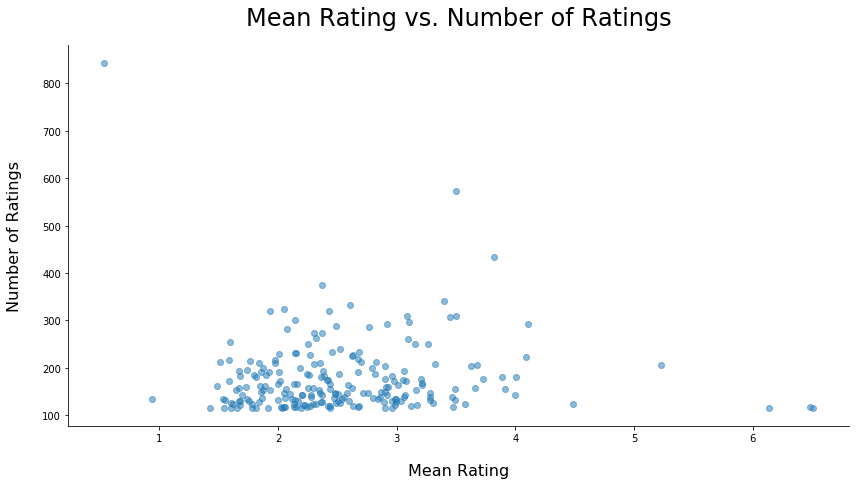

In [29]:
'''
 Part-4   ********* 'Weightage Rating' *************
    
Why and how to calculate 'Weightage Rating'
    
Why:
    Lets say, there is one book which got 2 rating with 9 & 10.. in this case, this book will be having kind of 
    heightest rating among all other books. But as there are only 2 user ratings given to this book so ideally it makes sense
    to sort the book list by 'weightage rating' instead of 'average rating'
    
How:
    A. Get the threshold value of 'Number of Rating' which a book at least should have to get recommended. For this 'm' is 
        calcualted with quantile for e.g. item_with_most_ratings['bookRating'].quantile(0.9999)
    B. Filter the list of books which are having 'Number of Rating' > m
    C. Calculate the 'Weightage Rating' by applying formula using 'Mean_Rating' of a book, Total Number of Rating of a book,
        'mean rating' of all books and 'm'
    
'''

C=df['bookRating'].mean()
print('Mean Rating of all books: ', C)
print('Threshold value of Num_Rating: ', m)
def weighted_rating(x):
    v = x['Num_Ratings']
    R = x['Mean_Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

ratings_df = pd.DataFrame()
ratings_df['ISBN'] = df.groupby('ISBN')['bookRating'].groups.keys()
ratings_df['Mean_Rating'] = df.groupby('ISBN')['bookRating'].mean().values
ratings_df['Num_Ratings'] = df.groupby('ISBN')['bookRating'].count().values
ratings_df = ratings_df[ratings_df['Num_Ratings'] >= m]
ratings_df['Weightage_Ratings'] = ratings_df.apply(weighted_rating, axis=1)

ratings_df_clip= ratings_df.sort_values(by='Weightage_Ratings', ascending=False)[:10].reset_index()

print('Displaying top 10 books with heightest weightage rating')
print(ratings_df_clip.head(10).to_string())

fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Mean Rating vs. Number of Ratings', fontsize=24, pad=20)
ax.set_xlabel('Mean Rating', fontsize=16, labelpad=20)
ax.set_ylabel('Number of Ratings', fontsize=16, labelpad=20)

plt.scatter(ratings_df['Mean_Rating'], ratings_df['Num_Ratings'], alpha=0.5)

In [30]:
# Part-5 Train the model with different algorithms and evaluate performance of each algorithm

reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df[['userID', 'ISBN', 'bookRating']], reader)

benchmark = []

# for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
for algorithm in [SVD(), BaselineOnly(), SlopeOne(), NMF()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results, calculate 'mean' and put into DF. Also, append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
print(surprise_results)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
              test_rmse  fit_time  test_time
Algorithm                                   
BaselineOnly   3.376501  0.181345   0.379338
SlopeOne       3.477833  0.843342   5.036022
SVD            3.547725  7.045052   0.526670
NMF            3.846307  7.957050   0.444341


In [33]:
# Part-6 Train the model with different algorithms such as SVD, Baseline, KNNBaseline Item/User similarity
# and evaluate performance of each algorithm by 'RMSE' score

reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df[['userID', 'ISBN', 'bookRating']], reader)

bsl_options = {'method': 'als', 'n_epochs': 5,
               'reg_u': 12, 'reg_i': 5 }

trainset, testset = train_test_split(data, test_size=0.25)

algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset[:200])
print('Accuracy Score using Baseline Algorithm')
accuracy.rmse(predictions)

svdalgo = SVD(n_factors=160, n_epochs=100, lr_all=0.005, reg_all=0.1, random_state=0)
svdpredictions = svdalgo.fit(trainset).test(testset[:200])
print('\nAccuracy Score using SVD Algorithm')
accuracy.rmse(svdpredictions)


sim_options = {'name': 'pearson_baseline', 'user_based': False}
itemAlgo = KNNBaseline(sim_options=sim_options)
itempredictions = itemAlgo.fit(trainset).test(testset[:200])
print('\nAccuracy Score using KNNBaseline Item-Item similarity Algorithm')
accuracy.rmse(itempredictions)


sim_options = {'name': 'pearson_baseline', 'user_based': True}
userAlgo = KNNBaseline(sim_options=sim_options)
userpredictions = userAlgo.fit(trainset).test(testset[:200])
print('\nAccuracy Score using KNNBaseline User-user similarity Algorithm')
accuracy.rmse(userpredictions)

Estimating biases using als...
Accuracy Score using Baseline Algorithm
RMSE: 3.2892

Accuracy Score using SVD Algorithm
RMSE: 3.4517
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Accuracy Score using KNNBaseline Item-Item similarity Algorithm
RMSE: 3.4929
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Accuracy Score using KNNBaseline User-user similarity Algorithm
RMSE: 3.6293


3.629347558612514

In [47]:
# Part-7 Get the Top 'n' worst and best predictions

def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
df.head()


best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]
print('Worst Predictions for Baseline Algorithm')
print(worst_predictions.to_string())
print('***********************')
print('Best Predictions for Baseline Algorithm')
print(best_predictions.to_string())

Worst Predictions for Baseline Algorithm
        uid         iid   rui       est                    details  Iu  Ui       err
90   111578  0679781587  10.0  3.790605  {'was_impossible': False}   0   0  6.209395
166   19681  0373484003   9.0  2.198908  {'was_impossible': False}   0   0  6.801092
144  196077  0061099732   7.0  0.117757  {'was_impossible': False}   0   0  6.882243
54    48046  0142004278   9.0  2.072468  {'was_impossible': False}   0   0  6.927532
62   187624  0345370775  10.0  2.850576  {'was_impossible': False}   0   0  7.149424
78   110483  0441001971  10.0  2.757194  {'was_impossible': False}   0   0  7.242806
191  244171  038549081X  10.0  2.644253  {'was_impossible': False}   0   0  7.355747
178  248464  006019491X  10.0  2.234684  {'was_impossible': False}   0   0  7.765316
22    59172  0440185327  10.0  1.609304  {'was_impossible': False}   0   0  8.390696
115  201017  1401088945  10.0  0.171997  {'was_impossible': False}   0   0  9.828003
***********************


In [46]:
# Part -8 - Predict a rating for a given user id and book id combination with different algorithm

ratings_dict = {'ISBN': ['211', '0020442203', '0060915544', '0060977493'],
                'userID': [29999911, 11676, 198711, 153662],
                'bookRating': [10.0, 2.58, 7, 3]}

test_df = pd.DataFrame(ratings_dict)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(test_df[['userID', 'ISBN', 'bookRating']], reader)
trainset, testset = train_test_split(data, test_size=.99)

baselinepred = algo.test(testset)
baselineodf = pd.DataFrame(baselinepred, columns=['uid', 'iid', 'rui', 'est', 'details'])

svdpred = svdalgo.test(testset)
svdodf = pd.DataFrame(svdpred, columns=['uid', 'iid', 'rui', 'est', 'details'])

itempred = itemAlgo.test(testset)
itemodf = pd.DataFrame(itempred, columns=['uid', 'iid', 'rui', 'est', 'details'])

userpred = userAlgo.test(testset)
userodf = pd.DataFrame(userpred, columns=['uid', 'iid', 'rui', 'est', 'details'])


baselineodf = baselineodf.rename(columns={"uid": "userID", "est": "Baseline_Rating"})
merge_df = pd.merge(test_df, baselineodf, on='userID', how='inner')
merge_df.drop(['iid', 'rui', 'details'], axis=1, inplace=True)

svdodf = svdodf.rename(columns={"uid": "userID", "est": "SVD_Rating"})
merge_df = pd.merge(merge_df, svdodf, on='userID', how='inner')
merge_df.drop(['iid', 'rui', 'details'], axis=1, inplace=True)

itemodf = itemodf.rename(columns={"uid": "userID", "est": "KNNBaseline_Item_Rating"})
merge_df = pd.merge(merge_df, itemodf, on='userID', how='inner')
merge_df.drop(['iid', 'rui', 'details'], axis=1, inplace=True)

userodf = userodf.rename(columns={"uid": "userID", "est": "KNNBaseline_User_Rating"})
merge_df = pd.merge(merge_df, userodf, on='userID', how='inner')
merge_df.drop(['iid', 'rui', 'details'], axis=1, inplace=True)

merge_df

,ISBN,userID,bookRating,Baseline_Rating,SVD_Rating,KNNBaseline_Item_Rating,KNNBaseline_User_Rating
0,211,29999911,10.00,2.343078,2.343078,2.343078,2.343078
1,0020442203,11676,2.58,5.157867,3.036341,5.734478,3.921663
2,0060915544,198711,7.00,1.436595,0.742795,0.824003,0.000000
3,0060977493,153662,3.00,2.085136,2.847225,1.626284,1.852399
